In [1]:
#!/usr/bin/env python

import numpy as np

import matplotlib.pyplot as plt

from gnssr.simulator.ddm import *
from gnssr.simulator.simulation_configuration import *

from gnssr.targets import *
from gnssr.tds.tds_data import *
from gnssr.tds.detection.find_targets import *
from gnssr.utils import *
from gnssr.simulator.waf import *

import cv2


sim_config = simulation_configuration()
sim_config.jacobian_type = 'spherical'

delay_chip = sim_config.delay_chip

# Decent noise results
#file_root_name = '2017-03-12-H18'
#target = targets['hibernia']
#group = '000035'
#index = 675

file_root_name = '2015-12-04-H18'
target = targets['devils_tower']
group = '000066'
index =  385

tds = tds_data(file_root_name, group, index)

mean_wind = tds.get_wind()
p = target_processor_power();
n = 1  
p.n = n
for i in range(index - n, index + 2):
    tds.set_group_index(group, i)
    ddm_i = normalize(tds.rootgrp.groups[group].variables['DDM'][i].data)*tds.peak_power()
    p.process_ddm(ddm_i)
    wind = tds.get_wind() 
    if (wind != None):
        print("wind: {0}".format(wind))
        mean_wind += wind
        mean_wind /= 2
ddm_tds = np.copy(p.sea_clutter)
print("mean wind: {0}".format(mean_wind))

sim_config.u_10 = 2.2 
sim_config.phi_0 = -160*np.pi/180

# Plot TDS DDM sea clutter
tds.set_group_index(group, index)
r_sp, lat_sp, lon_sp = tds.find_sp();
datenum = tds.rootgrp.groups[tds.group].variables['IntegrationMidPointTime'][tds.index]

string = str(datenum_to_pytime(float(datenum))) \
    + ' Lat: ' + "{0:.2f}".format(tds.lat_sp_tds) \
    + ' Lon: ' + "{0:.2f}".format(tds.lon_sp_tds)

tds_number_of_delay_pixels = tds.metagrp.groups[tds.group].NumberOfDelayPixels
tds_number_of_doppler_pixels = tds.metagrp.groups[tds.group].NumberOfDopplerPixels

tds_delay_start = tds.calculate_delay_increment_chips(0)
tds_delay_end = tds.calculate_delay_increment_chips(tds_number_of_delay_pixels-1)
tds_delay_resolution = (tds_delay_end-tds_delay_start)/128

tds_doppler_start = tds.calculate_doppler_increment(-np.floor(tds_number_of_doppler_pixels/2))
tds_doppler_end = tds.calculate_doppler_increment(np.floor(tds_number_of_doppler_pixels/2 - 0.5))
tds_doppler_resolution = 500

fig_tds, ax_tds = plt.subplots(1,figsize=(10, 4))
plt.title('TDS-1 Experimental Data')
plt.xlabel('C/A chips')
plt.ylabel('Hz')
contour_tds = ax_tds.imshow(ddm_tds, cmap='jet', 
        extent=(tds_delay_start, tds_delay_end, tds_doppler_end, tds_doppler_start), 
        aspect=(tds_number_of_doppler_pixels/tds_number_of_delay_pixels)/np.abs(tds_doppler_start/tds_delay_start)
        )
t = plt.text(0.01, 0.85, string, {'color': 'w', 'fontsize': 12}, transform=ax_tds.transAxes)
cbar = fig_tds.colorbar(contour_tds, label='Power')

# Load TDS Geometry in simulation configuration
n_z = unit_vector(ellip_norm(tds.r_sp_tds))
n_x = unit_vector(np.cross(n_z, tds.r_sp_tds-tds.r_t))
n_y = unit_vector(np.cross(n_z, n_x))

v_tx = np.dot(tds.v_t, n_x)
v_ty = np.dot(tds.v_t, n_y)
v_tz = np.dot(tds.v_t, n_z)

v_rx = np.dot(tds.v_r, n_x)
v_ry = np.dot(tds.v_r, n_y)
v_rz = np.dot(tds.v_r, n_z)

sim_config.set_scenario_local_ref(
    h_r = np.dot((tds.r_r - tds.r_sp_tds), n_z),
    h_t = np.dot((tds.r_t - tds.r_sp_tds), n_z),
    elevation = angle_between(n_y, tds.r_t-tds.r_sp_tds),
    v_t = np.array([v_tx,v_ty,v_tz]),
    v_r = np.array([v_rx,v_ry,v_rz])
    )

# DDM
sim_config.delay_increment_start = tds_delay_start*delay_chip
sim_config.delay_increment_end = tds_delay_end*delay_chip
sim_config.delay_resolution = (sim_config.delay_increment_end - sim_config.delay_increment_start)/tds_number_of_delay_pixels/3
sim_config.doppler_increment_start = tds_doppler_start
sim_config.doppler_increment_end = tds_doppler_end + tds_doppler_resolution
sim_config.doppler_resolution = (sim_config.doppler_increment_end - sim_config.doppler_increment_start)/tds_number_of_doppler_pixels/3

ddm_sim = (simulate_ddm(sim_config))

fig_ddm, ax_ddm = plt.subplots(1,figsize=(10, 4))
plt.title('DDM original simulation')
plt.xlabel('C/A chips')
plt.ylabel('Hz')
contour_ddm = ax_ddm.imshow(ddm_sim, cmap='jet', 
        extent=(sim_config.delay_increment_start, sim_config.delay_increment_end, sim_config.doppler_increment_end, sim_config.doppler_increment_start), 
        aspect="auto"
        )
cbar = fig_ddm.colorbar(contour_ddm, label='Normalized Power')

# Image downscaling to desired resolution:
fig_ddm_rescaled, ax_ddm_rescaled = plt.subplots(1,figsize=(10, 4))
plt.title('Simulation Rescaled')
plt.xlabel('C/A chips')
plt.ylabel('Hz')

ddm_rescaled = rescale(ddm_sim, tds_number_of_doppler_pixels, tds_number_of_delay_pixels) 

# Noise
waf_delay_increment_values = list(np.arange(
    -tds_delay_end*delay_chip, 
    tds_delay_end*delay_chip + tds_delay_resolution*delay_chip, 
    tds_delay_resolution*delay_chip
    ))
waf_doppler_increment_values = list(np.arange(
    tds_doppler_start, 
    tds_doppler_end + tds_doppler_resolution, 
    tds_doppler_resolution
    ))
waf_delay_grid, waf_doppler_grid = np.meshgrid(waf_delay_increment_values, waf_doppler_increment_values)
waf_matrix = woodward_ambiguity_function(waf_delay_grid, waf_doppler_grid, sim_config)**2

T_noise_receiver = 225
k_b = 1.38e-23 # J/K
y_noise = 1/sim_config.coherent_integration_time*k_b*T_noise_receiver

p1 = target_processor_power();
n = 1*1000 
p1.n = n
p1.tau = 0.08
ddm_noise = np.zeros(ddm_rescaled.shape)
# TODO: put this into the target processor or do the right average to the 
#tds data (even better)
for i in range(n+1):
    print("i: {0}".format(i))
    #ddm_noise_i = np.abs(signal.convolve2d(noise_i, waf_matrix, mode='same'))
    noise_i = y_noise*(np.random.rand(ddm_rescaled.shape[0], ddm_rescaled.shape[1]))
    ddm_noise += (noise_i + ddm_rescaled)
    #p1.process_ddm(np.abs(ddm_rescaled + ddm_noise_i))
#ddm_rescaled = p1.sea_clutter
ddm_rescaled = ddm_noise/n

ddm_rescaled[0,:] = ddm_rescaled[2,:]
ddm_rescaled[1,:] = ddm_rescaled[2,:]
ddm_rescaled[:,0] = ddm_rescaled[:,2]
ddm_rescaled[:,1] = ddm_rescaled[:,2]

contour_res = ax_ddm_rescaled.imshow(ddm_rescaled, cmap='jet', 
        extent=(tds_delay_start, tds_delay_end, tds_doppler_end, tds_doppler_start), 
        aspect=(tds_number_of_doppler_pixels/tds_number_of_delay_pixels)/np.abs(tds_doppler_start/tds_delay_start)
        )
cbar = fig_ddm_rescaled.colorbar(contour_res, label='Normalized Power', shrink=0.35)



wind: 2.541365623474121
wind: 2.2821803092956543
wind: 2.4690065383911133
mean wind: 2.407991588115692
spherical it: 2 - err: 1.0



/home/woowapdabug/projects/thesis/py_venv_gnssr/src/gnssr/simulator/jacobian/spherical.py:149: RuntimeWarning: divide by zero encountered in true_divide
  rel_err_z1 = abs(z1_new - z1_old)/abs(z1_old)
/home/woowapdabug/projects/thesis/py_venv_gnssr/src/gnssr/simulator/jacobian/spherical.py:149: RuntimeWarning: invalid value encountered in true_divide
  rel_err_z1 = abs(z1_new - z1_old)/abs(z1_old)
/home/woowapdabug/projects/thesis/py_venv_gnssr/src/gnssr/simulator/jacobian/spherical.py:150: RuntimeWarning: divide by zero encountered in true_divide
  rel_err_z2 = abs(z2_new - z2_old)/abs(z2_old)
/home/woowapdabug/projects/thesis/py_venv_gnssr/src/gnssr/simulator/jacobian/spherical.py:150: RuntimeWarning: invalid value encountered in true_divide
  rel_err_z2 = abs(z2_new - z2_old)/abs(z2_old)


spherical it: 3 - err: 0.34405543167628283

spherical it: 4 - err: 1.0

spherical it: 5 - err: 0.051472029750176646

spherical it: 6 - err: 1.0

spherical it: 7 - err: 0.04308641890381443

spherical it: 8 - err: 1.0

spherical it: 9 - err: 0.03481935097728773

spherical it: 10 - err: 1.0

spherical it: 2 - err: 1.0

spherical it: 3 - err: 0.3441629854159297

spherical it: 4 - err: 1.0

spherical it: 5 - err: 0.031249672222244118

spherical it: 6 - err: 1.0

spherical it: 7 - err: 0.015044994067638867

spherical it: 8 - err: 1.0

spherical it: 9 - err: 0.008149829752551694

spherical it: 10 - err: 1.0

spherical it: 2 - err: 1.0

spherical it: 3 - err: 0.34394646330127054

spherical it: 4 - err: 1.0

spherical it: 5 - err: 0.031249672222244118

spherical it: 6 - err: 1.0

spherical it: 7 - err: 0.015044994067638867

spherical it: 8 - err: 1.0

spherical it: 9 - err: 0.008149829752551694

spherical it: 10 - err: 1.0

spherical it: 2 - err: 1.0

spherical it: 3 - err: 0.3438801857959213



/home/woowapdabug/projects/thesis/py_venv_gnssr/src/gnssr/simulator/waf.py:77: RuntimeWarning: invalid value encountered in true_divide
  np.sin(x)/(x)


i: 0
i: 1
i: 2
i: 3
i: 4
i: 5
i: 6
i: 7
i: 8
i: 9
i: 10
i: 11
i: 12
i: 13
i: 14
i: 15
i: 16
i: 17
i: 18
i: 19
i: 20
i: 21
i: 22
i: 23
i: 24
i: 25
i: 26
i: 27
i: 28
i: 29
i: 30
i: 31
i: 32
i: 33
i: 34
i: 35
i: 36
i: 37
i: 38
i: 39
i: 40
i: 41
i: 42
i: 43
i: 44
i: 45
i: 46
i: 47
i: 48
i: 49
i: 50
i: 51
i: 52
i: 53
i: 54
i: 55
i: 56
i: 57
i: 58
i: 59
i: 60
i: 61
i: 62
i: 63
i: 64
i: 65
i: 66
i: 67
i: 68
i: 69
i: 70
i: 71
i: 72
i: 73
i: 74
i: 75
i: 76
i: 77
i: 78
i: 79
i: 80
i: 81
i: 82
i: 83
i: 84
i: 85
i: 86
i: 87
i: 88
i: 89
i: 90
i: 91
i: 92
i: 93
i: 94
i: 95
i: 96
i: 97
i: 98
i: 99
i: 100
i: 101
i: 102
i: 103
i: 104
i: 105
i: 106
i: 107
i: 108
i: 109
i: 110
i: 111
i: 112
i: 113
i: 114
i: 115
i: 116
i: 117
i: 118
i: 119
i: 120
i: 121
i: 122
i: 123
i: 124
i: 125
i: 126
i: 127
i: 128
i: 129
i: 130
i: 131
i: 132
i: 133
i: 134
i: 135
i: 136
i: 137
i: 138
i: 139
i: 140
i: 141
i: 142
i: 143
i: 144
i: 145
i: 146
i: 147
i: 148
i: 149
i: 150
i: 151
i: 152
i: 153
i: 154
i: 155
i: 156
i: 157
i: 1

Text(0, 0.5, 'Hz')

In [2]:
plt.show()

/home/woowapdabug/.pyenv/versions/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in double_scalars


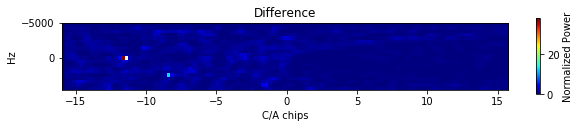

In [14]:

fig_diff, ax_diff = plt.subplots(1,figsize=(10, 4))
plt.title('Difference')
plt.xlabel('C/A chips')
plt.ylabel('Hz')

ddm_diff = np.copy(ddm_rescaled)
#ddm_diff = np.abs(ddm_rescaled - ddm_tds)

for row_i, row in enumerate(ddm_diff):
    for col_i, val in enumerate(row):
        col_i_shift = col_i
        row_i_shift = row_i
        col_shift = 0
        row_shift = 0 
        if (col_i + col_shift) >= 0 and (col_i + col_shift) < 128:
            col_i_shift += col_shift
        if (row_i + row_shift) >= 0 and (row_i + row_shift) < 20:
            row_i_shift += row_shift
        val_tds = ddm_tds[row_i_shift,col_i_shift]
        val = ddm_rescaled[row_i,col_i]
        if row_i == 0 :
            ddm_diff[row_i,col_i] = 0
        elif col_i == 0:
            ddm_diff[row_i,col_i] = 0
        else:
            ddm_diff[row_i,col_i] = np.abs((val-val_tds)/val_tds)
#np.place(ddm_diff, ddm_diff < 0, np.nan)

im = ax_diff.imshow(ddm_diff, cmap='jet', 
        extent=(tds_delay_start, tds_delay_end, tds_doppler_end, tds_doppler_start), 
        aspect=(tds_number_of_doppler_pixels/tds_number_of_delay_pixels)/np.abs(tds_doppler_start/tds_delay_start)
        )
cbar = fig_diff.colorbar(im, label='Normalized Power', shrink=0.35)


plt.show()